In [55]:
import json

import numpy as np
import pandas as pd
import pymongo
import scipy
from bson import ObjectId, json_util
from pandas.io.json import json_normalize
from pymongo import MongoClient as Connection
from scipy import sparse, spatial
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

#scientific notation disabled form smaller numbers
pd.options.display.float_format = '{:.5f}'.format

# alles resultate anzeigen und nicht nur das letzte
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)

In [56]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [57]:

connection = Connection()
db = connection.recipe_db
input_data = db.recipes_test_copy
#data = pd.DataFrame(list(input_data.find()))

data = json.loads(json_util.dumps(input_data.find()))
norm_data = json_normalize(data)


In [58]:
ingredients = json_normalize(data, record_path='ingredients', meta='id', record_prefix='ingredients_', errors='ignore' )
ingredients = pd.DataFrame(ingredients)

In [59]:
nutritions = json_normalize(data, record_path='nutritions',
                            meta=['id', 'prep_time', 'rating', 'rating_count', 'ready_in_time', 'review_count'])


In [60]:
# data cleansing

# schmeiss alle zutaten raus, die weniger als 5 mal verwendet werden
ingredients_filt = ingredients.groupby('ingredients_id').filter(lambda x: len(x) >= 5)

# drop alls rows with ingredients_id == 0
ingredients_filt = ingredients_filt[ingredients_filt.ingredients_id != 0]

# drop all duplicate
ingredients_filt = ingredients_filt.drop_duplicates(keep='first')

ingredients.id.count()
ingredients.id.nunique()
ingredients_filt.id.count()
ingredients_filt.id.nunique()

61194

6304

57865

6304

In [61]:
id_list = [215014, 8669, 16700, 16354, 12720, 8652, 8887, 51283, 45954, 213742, 14595, 219164, 16348, 143082, 8665, 11758, 223042, 236609, 8778, 65896, 24264, 11679, 141678, 9023]


recipe_db = pd.get_dummies(ingredients_filt['ingredients_id']).groupby(ingredients_filt['id']).apply(max)



In [62]:
# recipe_db.index.nunique()
recipe_db.count()
nutritions.id.count()

111      6304
126      6304
257      6304
388      6304
443      6304
         ... 
26706    6304
26934    6304
27343    6304
27388    6304
27805    6304
Length: 796, dtype: int64

126080

In [63]:
#filtere Rezepte aus den Metadaten anhand ihrerr Zutatenmenge raus. 
not_wanted_recipes = recipe_db[recipe_db.mask(recipe_db==0).count(axis=1) <= 4]
not_wanted_recipes
mask = nutritions['id'].isin(not_wanted_recipes.index.values)
nutritions_filt = nutritions.loc[~mask]
# nutritions_filt.id.nunique()
nutrition_db = nutritions_filt.pivot_table(
        index=['id'], 
         columns=['name'],
         values=['amount'],
).reset_index()

nutrition_db.set_index('id', inplace=True)
#remove multiindex 'amount'

nutrition_db.columns = nutrition_db.columns.droplevel(0)
# nutritions_filt.set_index('id', inplace=True)
nutrition_db = nutrition_db.dropna()
nutrition_db.index.nunique()

111    126    257    388    443    445    578    615    629    631    ...  24850  24865  25518  25522  26269  26706  26934  27343  27388  27805
id                                                                            ...                                                                      
8496        0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
8502        0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
8517        0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
8559        0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
8595        0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
242342      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
242357      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
244458      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
258878      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
260193      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0

[516 rows x 796 columns]

5753

In [64]:
recipe_db_filt = recipe_db[recipe_db.mask(recipe_db==0).count(axis=1) >= 5]

user_nutrition = nutrition_db[nutrition_db.index.isin(id_list)]
user_recipes = recipe_db_filt[recipe_db_filt.index.isin(id_list)]
# user_nutrition.columns = user_nutrition.columns.droplevel(0)
user_nutrition.index.nunique()
user_recipes.index.nunique()

22

22

In [65]:
# remove recipes which are missing in nutrition df from the ingredients tecipes dataframe
mask = recipe_db_filt.index.isin(nutrition_db.index.values)
recipe_db = recipe_db_filt.loc[mask]

recipe_db

111    126    257    388    443    445    578    615    629    631    ...  24850  24865  25518  25522  26269  26706  26934  27343  27388  27805
id                                                                            ...                                                                      
6806        0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
6900        0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
7198        0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
8493        0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
8494        0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...
261608      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
263611      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
263744      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
263799      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0
263813      0      0      0      0      0      0      0      0      0      0  ...      0      0      0      0      0      0      0      0      0      0

[5753 rows x 796 columns]

In [66]:
## Jaccard - rezept zu rezept vergelich

result_array = cdist(user_recipes, recipe_db,'jaccard')
result_2 = pd.DataFrame(result_array, columns=recipe_db.index.values, index=user_recipes.index.values)
# result_2

result_10 = pd.DataFrame(result_2.sum(), columns=['jaccard_distance_sum'])
result_10 = result_10.sort_values(by='jaccard_distance_sum')

result_10

jaccard_distance_sum
102235              18.40949
11732               18.45941
16416               18.58403
25927               18.58730
8887                18.64538
...                      ...
34912               22.00000
17610               22.00000
57243               22.00000
15699               22.00000
34700               22.00000

[5753 rows x 1 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126303b10>]],
      dtype=object)

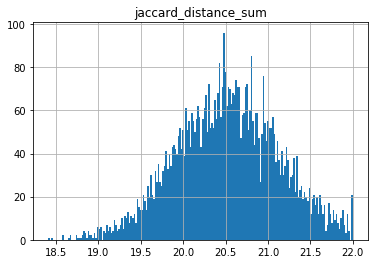

In [67]:
out = result_10.hist(column='jaccard_distance_sum', bins=200)
out

In [68]:
##Euklidische Distanz - rezept zu rezept vergelich
# minkowski(u, v, p=2, w=None)
# rec = []
# rec = {
#     "Calcium":[1],
#     "Calories":[1],
#     "Calories from Fat":[1],
#     "Carbohydrates":[1],
#     "Cholesterol":[1],
#     "Dietary Fiber":[1],
#     "Fat":[1],
#     "Folate":[1],
#     "Iron":[1],
#     "Magnesium":[1],
#     "Niacin Equivalents":[1],
#     "Potassium":[1],
#     "Protein":[1],
#     "Saturated Fat":[1],
#     "Sodium":[1],
#     "Sugars":[1],
#     "Thiamin":[1],
#     "Vitamin A - IU":[1],
#     "Vitamin B6":[1],
#     "Vitamin C":[1]}

rec_2 = [
    #"Calcium":[1],
    1,
   # "Calories":[1],
    1,
   # "Calories from Fat":[1],
    1,
    #"Carbohydrates":[1],
    1,
    #"Cholesterol":[1],
    1,
    #"Dietary Fiber	":[1],
    1,
    #"Fat":[1],
    1,
    #"Folate":[1],
    1,
    #"Iron":[1],
    1,
    #"Magnesium":[1],
    1,
    #"Niacin Equivalents":[1],
    1,
    #"Potassium":[1],
    1,
    #"Protein":[1],
    1,
    #"Saturated Fat":[1],
    1,
    #"Sodium":[1],
    1,
    #"Sugars":[1],
    1,
    #"Thiamin":[1],
    1,
    #"Vitamin A - IU":[1],
    1,
    #"Vitamin B6":[1],
    1,
    #"Vitamin C":[1]}
    1]

# 19–30 empfohlene nährwerte pro tag #https://www.ncbi.nlm.nih.gov/books/NBK56068/table/summarytables.t4/?report=objectonly
daily_percentages = [
    # "Calcium":[1],
    333.3,
    # "Calories":[1],
    800,
    # "Calories from Fat":[1],
    0,
    # "Carbohydrates":[1],
    43.3,
    # "Cholesterol":[1],
    0,
    # "Dietary Fiber	":[1],
    8.3,
    # "Fat":[1],
    30,
    # "Folate":[1],
    133.3,
    # "Iron":[1],
    2.6,
    # "Magnesium":[1],
    133.3,
    # "Niacin Equivalents":[1],
    5.3,
    # "Potassium":[1],
    1,
    # "Protein":[1],
    18.6,
    # "Saturated Fat":[1],
    0,
    # "Sodium":[1],
    0.5,
    # "Sugars":[1],
    0,
    # "Thiamin":[1],
    0.4,
    # "Vitamin A - IU":[1],
    300,
    # "Vitamin B6":[1],
    0.43,
    # "Vitamin C":[1]}
    30]

# nutrition_db = nutrition_db[:-700]
# nutrition_db = nutrition_db.dropna()  
result_array = cdist(user_nutrition, nutrition_db, 'minkowski' , p = 2, w = rec_2)
result_2 = pd.DataFrame(result_array, columns=nutrition_db.index.values, index=user_nutrition.index.values)
# result_2

result_6 = pd.DataFrame(result_2.sum(), columns=['minkowski_distance_sum'])
result_6 = result_6.sort_values(by='minkowski_distance_sum')


In [69]:
test = result_6
test2 = result_10
# result_6.describe()
# out = result_6.hist(column='minkowski_distance_sum', bins=2000)
# out

In [70]:
result_6 = result_6[:-700]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d9f8050>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12156e310>]],
      dtype=object)

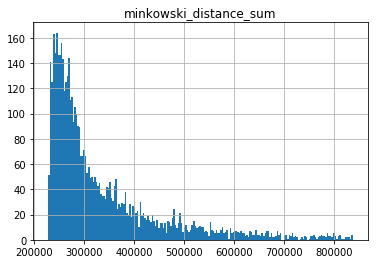

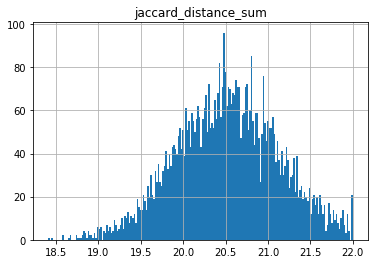

In [71]:
# result_6.describe()
out1 = result_6.hist(column='minkowski_distance_sum', bins=200)
out2 = result_10.hist(column='jaccard_distance_sum', bins=200)
out1
out2

In [72]:
outliers = test[test['minkowski_distance_sum'] > test['minkowski_distance_sum'].mean() + 1 * test['minkowski_distance_sum'].std()]


In [73]:
test.drop(outliers.index, inplace=True)

In [74]:
test.describe()
test2.describe()

minkowski_distance_sum
count              5434.00000
mean             395326.63000
std              249637.52189
min              228878.10598
25%              258749.59168
50%              298050.76970
75%              406744.89790
max             1668515.42817

jaccard_distance_sum
count            5753.00000
mean               20.52258
std                 0.60560
min                18.40949
25%                20.10286
50%                20.52340
75%                20.94773
max                22.00000

In [75]:
test2 = test2[test2.index.isin(test.index)]
test2

jaccard_distance_sum
102235              18.40949
11732               18.45941
16416               18.58403
25927               18.58730
8887                18.64538
...                      ...
34912               22.00000
17610               22.00000
57243               22.00000
15699               22.00000
34700               22.00000

[5434 rows x 1 columns]

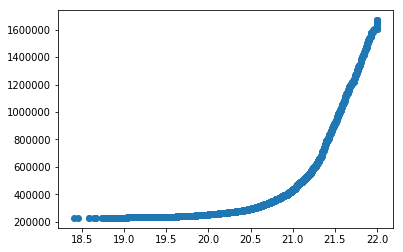

In [76]:
import pylab
pylab.scatter(test2.jaccard_distance_sum, test.minkowski_distance_sum)

In [77]:

# outliers

# # test2.drop(outliers.index, inplace=True)
# test2
result_6 = test
result_10 = test2

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fa67a50>]],
      dtype=object)

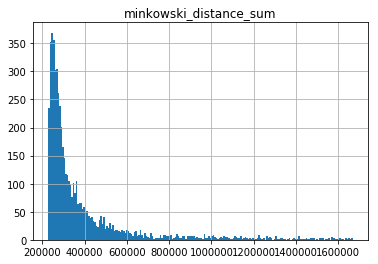

In [78]:
test1 = test.hist(column='minkowski_distance_sum', bins=200)
test1

In [79]:
result_6 = test

In [80]:
#minmax nomralisierung
from sklearn import preprocessing

nut_res = result_6
x = nut_res.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
# jac_res = jac_res.reset_index()
nut_res = pd.DataFrame(x_scaled, columns=nut_res.columns, index=nut_res.index)
# result_6 = pd.DataFrame(x_scaled, columns=result_6.columns)


jac_res = result_10
z = jac_res.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(z)
# jac_res = jac_res.reset_index()
jac_res = pd.DataFrame(z_scaled, columns=jac_res.columns, index=jac_res.index)

min_max_nut_recipe = pd.DataFrame(nut_res.minkowski_distance_sum + jac_res.jaccard_distance_sum, columns=jac_res.columns, index=jac_res.index)
min_max_nut_recipe = min_max_nut_recipe.sort_values(by='jaccard_distance_sum')
min_max_nut_recipe.rename(columns={'jaccard_distance_sum': 'min_max_nut_recipe'}, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121531fd0>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12112ff50>]],
      dtype=object)

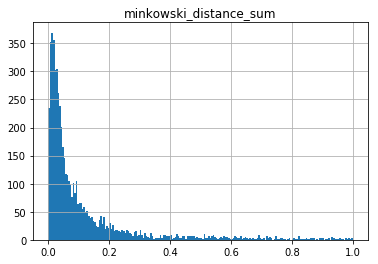

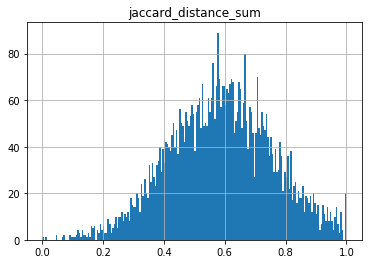

In [81]:
out1 = nut_res.hist(column='minkowski_distance_sum', bins=200)
out2 = jac_res.hist(column='jaccard_distance_sum', bins=200)
out1
out2

In [82]:
display_side_by_side(jac_res, nut_res, min_max_nut_recipe)

jaccard_distance_sum 
 
 
 
 
 102235 
 0.00000 
 
 
 11732 
 0.01390 
 
 
 16416 
 0.04861 
 
 
 25927 
 0.04952 
 
 
 8887 
 0.06570 
 
 
 51372 
 0.07035 
 
 
 223042 
 0.07178 
 
 
 132511 
 0.09063 
 
 
 55860 
 0.09278 
 
 
 213487 
 0.09654 
 
 
 228918 
 0.10498 
 
 
 14534 
 0.10620 
 
 
 8560 
 0.11142 
 
 
 19886 
 0.11266 
 
 
 24264 
 0.11518 
 
 
 219763 
 0.11556 
 
 
 220314 
 0.11831 
 
 
 8611 
 0.11899 
 
 
 8652 
 0.12023 
 
 
 78142 
 0.12233 
 
 
 70522 
 0.12387 
 
 
 71291 
 0.12642 
 
 
 143082 
 0.13178 
 
 
 85740 
 0.13200 
 
 
 245705 
 0.13458 
 
 
 17530 
 0.13496 
 
 
 8876 
 0.13879 
 
 
 215697 
 0.13932 
 
 
 19126 
 0.14116 
 
 
 8598 
 0.14416 
 
 
 238038 
 0.14766 
 
 
 218584 
 0.15060 
 
 
 222585 
 0.15078 
 
 
 26619 
 0.15342 
 
 
 219164 
 0.15703 
 
 
 8983 
 0.16009 
 
 
 165522 
 0.16056 
 
 
 57428 
 0.16233 
 
 
 11950 
 0.16284 
 
 
 9024 
 0.16313 
 
 
 229277 
 0.16375 
 
 
 240287 
 0.16537 
 
 
 55867 
 0.16591 
 
 
 218950 
 0.16818 
 
 
 75981 
 0.16956 
 
 
 11777 
 0.17000 
 
 
 143099 
 0.17137 
 
 
 14595 
 0.17138 
 
 
 77758 
 0.17423 
 
 
 86047 
 0.17426 
 
 
 17670 
 0.17440 
 
 
 19125 
 0.17460 
 
 
 87168 
 0.18059 
 
 
 229565 
 0.18245 
 
 
 8974 
 0.18400 
 
 
 8778 
 0.18412 
 
 
 26284 
 0.18888 
 
 
 8593 
 0.18949 
 
 
 16611 
 0.18969 
 
 
 53367 
 0.19006 
 
 
 12009 
 0.19189 
 
 
 109291 
 0.19257 
 
 
 69688 
 0.19270 
 
 
 58419 
 0.19364 
 
 
 16354 
 0.19445 
 
 
 126942 
 0.19492 
 
 
 238840 
 0.19660 
 
 
 238385 
 0.19783 
 
 
 231380 
 0.19919 
 
 
 16883 
 0.20000 
 
 
 222850 
 0.20004 
 
 
 61024 
 0.20123 
 
 
 69005 
 0.20158 
 
 
 22629 
 0.20231 
 
 
 230832 
 0.20361 
 
 
 57532 
 0.20475 
 
 
 223596 
 0.20793 
 
 
 16809 
 0.20929 
 
 
 146125 
 0.20942 
 
 
 90089 
 0.21225 
 
 
 16406 
 0.21274 
 
 
 25185 
 0.21333 
 
 
 8556 
 0.21538 
 
 
 90543 
 0.21539 
 
 
 9026 
 0.21759 
 
 
 240400 
 0.21773 
 
 
 232865 
 0.21806 
 
 
 8508 
 0.21832 
 
 
 79249 
 0.21898 
 
 
 30522 
 0.21911 
 
 
 217123 
 0.21919 
 
 
 140555 
 0.22115 
 
 
 11707 
 0.22203 
 
 
 8665 
 0.22212 
 
 
 9005 
 0.22247 
 
 
 8658 
 0.22313 
 
 
 20621 
 0.22328 
 
 
 238904 
 0.22424 
 
 
 88817 
 0.22753 
 
 
 215830 
 0.22888 
 
 
 102020 
 0.22997 
 
 
 105570 
 0.23003 
 
 
 246867 
 0.23232 
 
 
 217080 
 0.23347 
 
 
 237499 
 0.23364 
 
 
 240993 
 0.23457 
 
 
 214648 
 0.23520 
 
 
 8545 
 0.23589 
 
 
 16305 
 0.23589 
 
 
 213211 
 0.23787 
 
 
 21509 
 0.23883 
 
 
 14537 
 0.23899 
 
 
 231248 
 0.23955 
 
 
 88115 
 0.24005 
 
 
 17483 
 0.24055 
 
 
 44868 
 0.24160 
 
 
 216907 
 0.24198 
 
 
 77144 
 0.24232 
 
 
 168665 
 0.24268 
 
 
 220182 
 0.24288 
 
 
 219635 
 0.24288 
 
 
 232623 
 0.24470 
 
 
 17915 
 0.24497 
 
 
 8500 
 0.24555 
 
 
 102803 
 0.24591 
 
 
 215944 
 0.24599 
 
 
 12019 
 0.24630 
 
 
 72971 
 0.24918 
 
 
 55224 
 0.25019 
 
 
 70433 
 0.25050 
 
 
 233999 
 0.25061 
 
 
 162690 
 0.25083 
 
 
 8683 
 0.25167 
 
 
 52003 
 0.25213 
 
 
 8701 
 0.25307 
 
 
 11904 
 0.25379 
 
 
 159972 
 0.25448 
 
 
 36944 
 0.25499 
 
 
 14629 
 0.25645 
 
 
 28078 
 0.25681 
 
 
 214768 
 0.25715 
 
 
 15196 
 0.25758 
 
 
 256864 
 0.25777 
 
 
 84109 
 0.25798 
 
 
 18032 
 0.25824 
 
 
 214841 
 0.25846 
 
 
 57609 
 0.25891 
 
 
 169724 
 0.25982 
 
 
 13896 
 0.26062 
 
 
 40156 
 0.26067 
 
 
 221509 
 0.26079 
 
 
 244950 
 0.26086 
 
 
 19644 
 0.26211 
 
 
 86936 
 0.26267 
 
 
 83746 
 0.26278 
 
 
 8668 
 0.26301 
 
 
 222583 
 0.26320 
 
 
 16707 
 0.26331 
 
 
 217272 
 0.26384 
 
 
 28179 
 0.26464 
 
 
 236901 
 0.26520 
 
 
 46382 
 0.26523 
 
 
 234664 
 0.26746 
 
 
 34159 
 0.26754 
 
 
 12017 
 0.26764 
 
 
 56306 
 0.26793 
 
 
 135645 
 0.26873 
 
 
 40186 
 0.26929 
 
 
 11733 
 0.27011 
 
 
 230586 
 0.27016 
 
 
 54202 
 0.27059 
 
 
 8617 
 0.27093 
 
 
 21362 
 0.27178 
 
 
 8761 
 0.27194 
 
 
 198758 
 0.27232 
 
 
 56352 
 0.27332 
 
 
 214227 
 0.27359 
 
 
 78358 
 0.27388 
 
 
 36908 
 0

In [83]:
display(jac_res, nut_res, min_max_nut_recipe)

jaccard_distance_sum
102235               0.00000
11732                0.01390
16416                0.04861
25927                0.04952
8887                 0.06570
...                      ...
34912                1.00000
17610                1.00000
57243                1.00000
15699                1.00000
34700                1.00000

[5434 rows x 1 columns]

minkowski_distance_sum
12722                  0.00000
180791                 0.00016
20675                  0.00021
69721                  0.00035
146943                 0.00047
...                        ...
72064                  0.99175
81441                  0.99521
70447                  0.99903
160197                 0.99952
150258                 1.00000

[5434 rows x 1 columns]

min_max_nut_recipe
11732              0.01805
16416              0.05977
25927              0.06038
8887               0.07440
51372              0.07822
...                    ...
49769              1.73521
160197             1.74290
14670              1.76200
178054             1.84105
233550             1.93264

[5434 rows x 1 columns]

In [84]:
#robust-normalisierung
from sklearn import preprocessing

nut_res_robust = result_6
x = nut_res_robust.values #returns a numpy array
robust_scaler = preprocessing.RobustScaler()
x_scaled = robust_scaler.fit_transform(x)
# jac_res = jac_res.reset_index()
nut_res_robust = pd.DataFrame(x_scaled, columns=nut_res_robust.columns, index=nut_res_robust.index)
# result_6 = pd.DataFrame(x_scaled, columns=result_6.columns)


jac_res_robust = result_10
z = jac_res_robust.values #returns a numpy array
robust_scaler = preprocessing.RobustScaler()
z_scaled = robust_scaler.fit_transform(z)
# jac_res_robust = jac_res_robust.reset_index()
jac_res_robust = pd.DataFrame(z_scaled, columns=jac_res_robust.columns, index=jac_res_robust.index)



robust_scaling_nut_recipe = pd.DataFrame(nut_res_robust.minkowski_distance_sum + jac_res_robust.jaccard_distance_sum, columns=jac_res_robust.columns, index=jac_res_robust.index)
robust_scaling_nut_recipe = robust_scaling_nut_recipe.sort_values(by='jaccard_distance_sum')
robust_scaling_nut_recipe.rename(columns={'jaccard_distance_sum': 'robust_scaling_nut_recipe'}, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128110810>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12042a2d0>]],
      dtype=object)

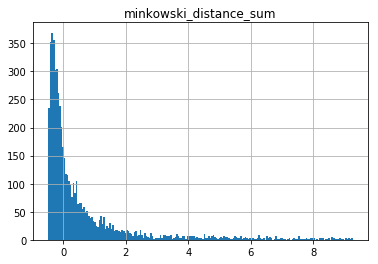

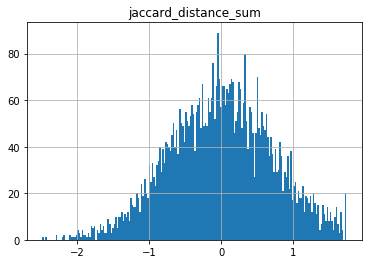

In [85]:
out1 = nut_res_robust.hist(column='minkowski_distance_sum', bins=200)
out2 = jac_res_robust.hist(column='jaccard_distance_sum', bins=200)
out1
out2

In [86]:
display_side_by_side(jac_res_robust, nut_res_robust)

jaccard_distance_sum 
 
 
 
 
 102235 
 -2.49156 
 
 
 11732 
 -2.43275 
 
 
 16416 
 -2.28592 
 
 
 25927 
 -2.28207 
 
 
 8887 
 -2.21364 
 
 
 51372 
 -2.19396 
 
 
 223042 
 -2.18790 
 
 
 132511 
 -2.10817 
 
 
 55860 
 -2.09909 
 
 
 213487 
 -2.08316 
 
 
 228918 
 -2.04749 
 
 
 14534 
 -2.04229 
 
 
 8560 
 -2.02020 
 
 
 19886 
 -2.01500 
 
 
 24264 
 -2.00431 
 
 
 219763 
 -2.00272 
 
 
 220314 
 -1.99108 
 
 
 8611 
 -1.98819 
 
 
 8652 
 -1.98297 
 
 
 78142 
 -1.97405 
 
 
 70522 
 -1.96755 
 
 
 71291 
 -1.95675 
 
 
 143082 
 -1.93410 
 
 
 85740 
 -1.93319 
 
 
 245705 
 -1.92225 
 
 
 17530 
 -1.92065 
 
 
 8876 
 -1.90444 
 
 
 215697 
 -1.90219 
 
 
 19126 
 -1.89443 
 
 
 8598 
 -1.88172 
 
 
 238038 
 -1.86692 
 
 
 218584 
 -1.85447 
 
 
 222585 
 -1.85374 
 
 
 26619 
 -1.84255 
 
 
 219164 
 -1.82728 
 
 
 8983 
 -1.81433 
 
 
 165522 
 -1.81234 
 
 
 57428 
 -1.80488 
 
 
 11950 
 -1.80271 
 
 
 9024 
 -1.80147 
 
 
 229277 
 -1.79885 
 
 
 240287 
 -1.79202 
 
 
 55867 
 -1.78971 
 
 
 218950 
 -1.78010 
 
 
 75981 
 -1.77426 
 
 
 11777 
 -1.77243 
 
 
 143099 
 -1.76661 
 
 
 14595 
 -1.76659 
 
 
 77758 
 -1.75453 
 
 
 86047 
 -1.75440 
 
 
 17670 
 -1.75379 
 
 
 19125 
 -1.75297 
 
 
 87168 
 -1.72762 
 
 
 229565 
 -1.71974 
 
 
 8974 
 -1.71319 
 
 
 8778 
 -1.71268 
 
 
 26284 
 -1.69254 
 
 
 8593 
 -1.68997 
 
 
 16611 
 -1.68914 
 
 
 53367 
 -1.68756 
 
 
 12009 
 -1.67981 
 
 
 109291 
 -1.67695 
 
 
 69688 
 -1.67640 
 
 
 58419 
 -1.67240 
 
 
 16354 
 -1.66900 
 
 
 126942 
 -1.66699 
 
 
 238840 
 -1.65991 
 
 
 238385 
 -1.65471 
 
 
 231380 
 -1.64895 
 
 
 16883 
 -1.64552 
 
 
 222850 
 -1.64533 
 
 
 61024 
 -1.64032 
 
 
 69005 
 -1.63882 
 
 
 22629 
 -1.63575 
 
 
 230832 
 -1.63024 
 
 
 57532 
 -1.62542 
 
 
 223596 
 -1.61195 
 
 
 16809 
 -1.60620 
 
 
 146125 
 -1.60568 
 
 
 90089 
 -1.59368 
 
 
 16406 
 -1.59162 
 
 
 25185 
 -1.58912 
 
 
 8556 
 -1.58044 
 
 
 90543 
 -1.58041 
 
 
 9026 
 -1.57109 
 
 
 240400 
 -1.57050 
 
 
 232865 
 -1.56912 
 
 
 8508 
 -1.56799 
 
 
 79249 
 -1.56521 
 
 
 30522 
 -1.56467 
 
 
 217123 
 -1.56432 
 
 
 140555 
 -1.55603 
 
 
 11707 
 -1.55230 
 
 
 8665 
 -1.55194 
 
 
 9005 
 -1.55046 
 
 
 8658 
 -1.54764 
 
 
 20621 
 -1.54702 
 
 
 238904 
 -1.54295 
 
 
 88817 
 -1.52903 
 
 
 215830 
 -1.52332 
 
 
 102020 
 -1.51874 
 
 
 105570 
 -1.51846 
 
 
 246867 
 -1.50878 
 
 
 217080 
 -1.50393 
 
 
 237499 
 -1.50320 
 
 
 240993 
 -1.49926 
 
 
 214648 
 -1.49660 
 
 
 8545 
 -1.49369 
 
 
 16305 
 -1.49369 
 
 
 213211 
 -1.48532 
 
 
 21509 
 -1.48126 
 
 
 14537 
 -1.48059 
 
 
 231248 
 -1.47821 
 
 
 88115 
 -1.47609 
 
 
 17483 
 -1.47397 
 
 
 44868 
 -1.46954 
 
 
 216907 
 -1.46794 
 
 
 77144 
 -1.46646 
 
 
 168665 
 -1.46496 
 
 
 220182 
 -1.46412 
 
 
 219635 
 -1.46412 
 
 
 232623 
 -1.45643 
 
 
 17915 
 -1.45529 
 
 
 8500 
 -1.45283 
 
 
 102803 
 -1.45130 
 
 
 215944 
 -1.45097 
 
 
 12019 
 -1.44966 
 
 
 72971 
 -1.43748 
 
 
 55224 
 -1.43320 
 
 
 70433 
 -1.43186 
 
 
 233999 
 -1.43139 
 
 
 162690 
 -1.43050 
 
 
 8683 
 -1.42694 
 
 
 52003 
 -1.42500 
 
 
 8701 
 -1.42101 
 
 
 11904 
 -1.41798 
 
 
 159972 
 -1.41503 
 
 
 36944 
 -1.41290 
 
 
 14629 
 -1.40672 
 
 
 28078 
 -1.40520 
 
 
 214768 
 -1.40375 
 
 
 15196 
 -1.40194 
 
 
 256864 
 -1.40111 
 
 
 84109 
 -1.40025 
 
 
 18032 
 -1.39915 
 
 
 214841 
 -1.39822 
 
 
 57609 
 -1.39632 
 
 
 169724 
 -1.39246 
 
 
 13896 
 -1.38907 
 
 
 40156 
 -1.38888 
 
 
 221509 
 -1.38836 
 
 
 244950 
 -1.38805 
 
 
 19644 
 -1.38276 
 
 
 86936 
 -1.38039 
 
 
 83746 
 -1.37991 
 
 
 8668 
 -1.37896 
 
 
 222583 
 -1.37815 
 
 
 16707 
 -1.37770 
 
 
 217272 
 -1.37546 
 
 
 28179 
 -1.37206 
 
 
 236901 
 -1.36968 
 
 
 46382 
 -1.36959 
 
 
 234664 
 -1.36015 
 
 
 34159 
 -1.35979 
 
 
 12017 
 -1.35939 
 
 
 56306 
 -1.35815 
 
 
 135645 
 -1.35475 
 
 
 40186 
 -1.35238 
 
 
 11733 
 -1.34893 
 
 
 230586 
 -1.34872 
 
 
 54202 
 -1.3469

In [87]:
#z-score-mormalisierung
z_min = (result_6 - result_6.mean())/result_6.std()
z_jac = (result_10 - result_10.mean())/result_10.std()

z_score_nut_recipe = pd.DataFrame(z_min.minkowski_distance_sum + z_jac.jaccard_distance_sum, columns=result_6.columns, index=z_min.index)
z_score_nut_recipe = z_score_nut_recipe.sort_values(by='minkowski_distance_sum')
z_score_nut_recipe.rename(columns={'minkowski_distance_sum': 'z_score_nut_recipe'}, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120cd7a50>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12037a650>]],
      dtype=object)

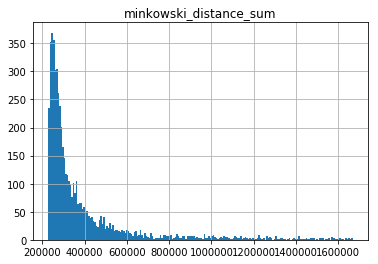

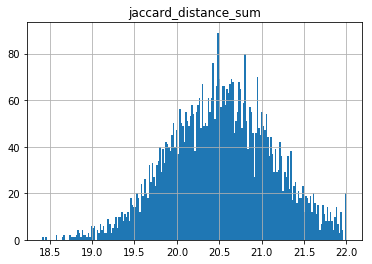

In [88]:
out1 = result_6.hist(column='minkowski_distance_sum', bins=200)
out2 = result_10.hist(column='jaccard_distance_sum', bins=200)
out1
out2

In [89]:
display_side_by_side(result_6, result_10)

minkowski_distance_sum 
 
 
 
 
 12722 
 228878.10598 
 
 
 180791 
 229110.22276 
 
 
 20675 
 229178.28556 
 
 
 69721 
 229387.93547 
 
 
 146943 
 229561.58543 
 
 
 74650 
 229640.18931 
 
 
 8712 
 229661.67788 
 
 
 14588 
 229734.20703 
 
 
 26614 
 229745.42811 
 
 
 221267 
 229786.07271 
 
 
 23386 
 229794.66260 
 
 
 213742 
 229829.56755 
 
 
 229090 
 229831.94556 
 
 
 233243 
 229836.32786 
 
 
 143362 
 230245.66709 
 
 
 215766 
 230261.10516 
 
 
 143375 
 230351.77115 
 
 
 212737 
 230450.98508 
 
 
 202463 
 230564.41055 
 
 
 35855 
 230578.67842 
 
 
 91478 
 230606.04573 
 
 
 217080 
 230704.02001 
 
 
 236114 
 230763.22523 
 
 
 68532 
 230764.70985 
 
 
 160042 
 230780.76415 
 
 
 228626 
 230797.59277 
 
 
 223381 
 230855.77202 
 
 
 218561 
 230923.53367 
 
 
 18830 
 231072.76001 
 
 
 132934 
 231097.93157 
 
 
 162936 
 231137.26171 
 
 
 43711 
 231169.33078 
 
 
 138107 
 231174.57880 
 
 
 219963 
 231209.83812 
 
 
 14951 
 231326.75152 
 
 
 177497 
 231364.76061 
 
 
 87149 
 231395.14520 
 
 
 8983 
 231437.52839 
 
 
 142951 
 231534.84201 
 
 
 185816 
 231547.60216 
 
 
 72845 
 231551.02858 
 
 
 11777 
 231574.82884 
 
 
 14690 
 231596.57718 
 
 
 80821 
 231638.72563 
 
 
 83846 
 231744.37198 
 
 
 239305 
 231750.72021 
 
 
 15302 
 231758.88730 
 
 
 22540 
 231793.51473 
 
 
 8621 
 231795.23246 
 
 
 229770 
 231798.68154 
 
 
 36196 
 231834.43000 
 
 
 82296 
 231923.09290 
 
 
 206569 
 231976.00586 
 
 
 179011 
 232049.38830 
 
 
 69549 
 232079.84972 
 
 
 149686 
 232219.31103 
 
 
 228630 
 232233.65375 
 
 
 72381 
 232235.90998 
 
 
 77515 
 232249.27007 
 
 
 17025 
 232271.95715 
 
 
 23813 
 232280.74736 
 
 
 244507 
 232295.50943 
 
 
 32148 
 232301.26632 
 
 
 15338 
 232311.34271 
 
 
 58921 
 232342.68519 
 
 
 20687 
 232348.39071 
 
 
 214578 
 232360.66635 
 
 
 166823 
 232367.99425 
 
 
 17801 
 232416.80883 
 
 
 48540 
 232438.91703 
 
 
 29450 
 232465.64173 
 
 
 14739 
 232558.05519 
 
 
 15530 
 232605.88228 
 
 
 230301 
 232640.19204 
 
 
 77008 
 232645.48191 
 
 
 25878 
 232688.05476 
 
 
 240287 
 232688.93059 
 
 
 74375 
 232717.39908 
 
 
 79701 
 232737.32030 
 
 
 14603 
 232789.81062 
 
 
 24498 
 232962.64436 
 
 
 145843 
 233020.03075 
 
 
 21226 
 233066.97286 
 
 
 230568 
 233081.17167 
 
 
 14680 
 233089.87807 
 
 
 237297 
 233114.04853 
 
 
 222506 
 233126.31997 
 
 
 24797 
 233128.49263 
 
 
 217843 
 233173.99461 
 
 
 221001 
 233213.09496 
 
 
 29460 
 233219.94584 
 
 
 18781 
 233255.36574 
 
 
 239230 
 233283.67006 
 
 
 19494 
 233290.22320 
 
 
 127628 
 233291.75027 
 
 
 11789 
 233314.05760 
 
 
 8653 
 233328.44697 
 
 
 57716 
 233369.87204 
 
 
 234348 
 233383.79604 
 
 
 223297 
 233388.37558 
 
 
 8601 
 233423.07729 
 
 
 46982 
 233424.08838 
 
 
 214648 
 233425.60595 
 
 
 213701 
 233454.20053 
 
 
 216564 
 233462.20742 
 
 
 34892 
 233462.82674 
 
 
 22686 
 233482.07851 
 
 
 38475 
 233494.72503 
 
 
 214399 
 233504.30293 
 
 
 216703 
 233506.99091 
 
 
 22292 
 233513.39091 
 
 
 77125 
 233527.45405 
 
 
 70739 
 233584.53591 
 
 
 84720 
 233598.60442 
 
 
 14714 
 233605.36852 
 
 
 103503 
 233617.96905 
 
 
 21507 
 233620.46355 
 
 
 21360 
 233623.56234 
 
 
 149975 
 233639.00410 
 
 
 8524 
 233641.22464 
 
 
 166477 
 233646.23884 
 
 
 228227 
 233660.27444 
 
 
 51154 
 233662.33561 
 
 
 213202 
 233668.57057 
 
 
 17178 
 233684.17802 
 
 
 72267 
 233690.63152 
 
 
 54611 
 233740.59413 
 
 
 24786 
 233749.36906 
 
 
 94377 
 233762.26853 
 
 
 8841 
 233785.26489 
 
 
 189058 
 233806.58922 
 
 
 218093 
 233828.49015 
 
 
 51738 
 233845.34182 
 
 
 69030 
 233845.78562 
 
 
 20036 
 233865.60730 
 
 
 142769 
 233877.56077 
 
 
 20621 
 233961.86473 
 
 
 85482 
 233965.17144 
 
 
 17212 
 233978.48635 
 
 
 22827 
 234003.27053 
 
 
 61704 
 234012.15372 
 
 
 8951 
 234041.60398 
 
 
 26637 
 234052.77592 
 
 
 232723 
 234058.10838 
 
 
 107915 
 234077.66682 
 
 
 

In [90]:
z_scaled

array([[-2.49156156],
       [-2.43274666],
       [-2.28592474],
       ...,
       [ 1.73870358],
       [ 1.73870358],
       [ 1.73870358]])

In [91]:
# summed_up = pd.DataFrame(columns='sum')
# result_6['sum'] = result_6.minkowski_distance_sum + result_10.jaccard_distance_sum
# result_6


In [92]:
display(result_6, result_10)

minkowski_distance_sum
12722             228878.10598
180791            229110.22276
20675             229178.28556
69721             229387.93547
146943            229561.58543
...                        ...
72064            1656641.83608
81441            1661625.98960
70447            1667116.81961
160197           1667823.57026
150258           1668515.42817

[5434 rows x 1 columns]

jaccard_distance_sum
102235              18.40949
11732               18.45941
16416               18.58403
25927               18.58730
8887                18.64538
...                      ...
34912               22.00000
17610               22.00000
57243               22.00000
15699               22.00000
34700               22.00000

[5434 rows x 1 columns]

In [93]:
display(result_6, result_10, min_max_nut_recipe, z_score_nut_recipe, robust_scaling_nut_recipe)


minkowski_distance_sum
12722             228878.10598
180791            229110.22276
20675             229178.28556
69721             229387.93547
146943            229561.58543
...                        ...
72064            1656641.83608
81441            1661625.98960
70447            1667116.81961
160197           1667823.57026
150258           1668515.42817

[5434 rows x 1 columns]

jaccard_distance_sum
102235              18.40949
11732               18.45941
16416               18.58403
25927               18.58730
8887                18.64538
...                      ...
34912               22.00000
17610               22.00000
57243               22.00000
15699               22.00000
34700               22.00000

[5434 rows x 1 columns]

min_max_nut_recipe
11732              0.01805
16416              0.05977
25927              0.06038
8887               0.07440
51372              0.07822
...                    ...
49769              1.73521
160197             1.74290
14670              1.76200
178054             1.84105
233550             1.93264

[5434 rows x 1 columns]

z_score_nut_recipe
11732             -4.02125
16416             -3.77660
25927             -3.77299
8887              -3.69029
51372             -3.66769
...                    ...
49769              5.99163
160197             6.01051
14670              6.13162
178054             6.59058
233550             7.13447

[5434 rows x 1 columns]

robust_scaling_nut_recipe
11732                    -2.85981
16416                    -2.64472
25927                    -2.64383
8887                     -2.59642
51372                    -2.58478
...                           ...
214619                    9.51714
14670                     9.57518
160197                    9.90866
178054                   10.19827
233550                   10.34360

[5434 rows x 1 columns]

In [94]:
robust_scaling_nut_recipe.index.values[:10]

array([ 11732,  16416,  25927,   8887,  51372, 213487,  55860, 228918,
         8611, 223042])

In [95]:
user_nutrition.describe()

name    Calcium  Calories  Calories from Fat  Carbohydrates  Cholesterol  Dietary Fiber      Fat    Folate     Iron  Magnesium  Niacin Equivalents  Potassium  Protein  Saturated Fat     Sodium   Sugars  Thiamin  Vitamin A - IU  Vitamin B6  Vitamin C
count  22.00000  22.00000           22.00000       22.00000     22.00000       22.00000 22.00000  22.00000 22.00000   22.00000            22.00000   22.00000 22.00000       22.00000   22.00000 22.00000 22.00000        22.00000    22.00000   22.00000
mean  159.99189 419.63661          202.54957       22.71136    108.69271        1.34103 22.50551  36.94701  2.34085   43.52666            14.29797  438.18231 30.30979        9.28729  914.82474  8.84147  0.22279       633.25011     0.54481    9.44859
std   204.64150 195.67102          127.00564       17.72938     57.42293        1.63049 14.11174  45.25523  1.38049   18.53427             5.82148  163.29511 10.81204        9.46412  421.18443  7.88883  0.23264       945.08919     0.25715   26.70116
min    16.54100 188.82200           63.26972        3.69344     49.55834        0.09812  7.02997   4.03500  0.67555   20.15258             6.12173  204.87420 15.14428        1.32642  261.17500  0.31000  0.04379        44.29399     0.22325    0.17663
25%    30.61873 289.89323          108.42730       11.71574     67.95188        0.29512 12.04748  11.17081  1.38157   29.70595            10.71160  334.04520 22.99077        3.16964  638.66735  2.94898  0.08939       141.86822     0.32555    2.08205
50%    64.30737 357.60735          180.02090       14.72541     96.42354        0.73333 20.00232  21.23022  1.91907   38.62819            11.50875  399.83440 28.34294        7.03607  896.44645  7.62589  0.15629       359.73285     0.50139    2.74364
75%   241.05728 475.43077          236.67387       31.33663    128.23378        1.44693 26.29710  31.97973  3.29331   54.11189            19.11362  502.88567 37.15344        9.84844 1129.72975 12.07341  0.28818       613.08930     0.73764    5.35917
max   863.07260 934.62580          555.39700       66.65271    270.80000        6.01560 61.71077 165.90260  6.70979   90.07227            25.98078  913.57040 61.73117       37.16240 2203.72100 30.60239  1.09490      4342.76200     1.10925  128.18110

In [96]:
display(jac_res_robust, nut_res_robust, robust_scaling_nut_recipe)

jaccard_distance_sum
102235              -2.49156
11732               -2.43275
16416               -2.28592
25927               -2.28207
8887                -2.21364
...                      ...
34912                1.73870
17610                1.73870
57243                1.73870
15699                1.73870
34700                1.73870

[5434 rows x 1 columns]

minkowski_distance_sum
12722                 -0.46740
180791                -0.46583
20675                 -0.46537
69721                 -0.46395
146943                -0.46278
...                        ...
72064                  9.17996
81441                  9.21364
70447                  9.25074
160197                 9.25552
150258                 9.26019

[5434 rows x 1 columns]

robust_scaling_nut_recipe
11732                    -2.85981
16416                    -2.64472
25927                    -2.64383
8887                     -2.59642
51372                    -2.58478
...                           ...
214619                    9.51714
14670                     9.57518
160197                    9.90866
178054                   10.19827
233550                   10.34360

[5434 rows x 1 columns]

In [97]:
result_6[:10].index.values

array([ 12722, 180791,  20675,  69721, 146943,  74650,   8712,  14588,
        26614, 221267])

In [98]:
# nutrition_db.isnull().values.sum()
# nutrition_db
# df1 = nutrition_db[nutrition_db.isnull().any(axis=1)]

# df1
# result_6['minkowski_distance_sum']
user_nutrition.describe()

name    Calcium  Calories  Calories from Fat  Carbohydrates  Cholesterol  Dietary Fiber      Fat    Folate     Iron  Magnesium  Niacin Equivalents  Potassium  Protein  Saturated Fat     Sodium   Sugars  Thiamin  Vitamin A - IU  Vitamin B6  Vitamin C
count  22.00000  22.00000           22.00000       22.00000     22.00000       22.00000 22.00000  22.00000 22.00000   22.00000            22.00000   22.00000 22.00000       22.00000   22.00000 22.00000 22.00000        22.00000    22.00000   22.00000
mean  159.99189 419.63661          202.54957       22.71136    108.69271        1.34103 22.50551  36.94701  2.34085   43.52666            14.29797  438.18231 30.30979        9.28729  914.82474  8.84147  0.22279       633.25011     0.54481    9.44859
std   204.64150 195.67102          127.00564       17.72938     57.42293        1.63049 14.11174  45.25523  1.38049   18.53427             5.82148  163.29511 10.81204        9.46412  421.18443  7.88883  0.23264       945.08919     0.25715   26.70116
min    16.54100 188.82200           63.26972        3.69344     49.55834        0.09812  7.02997   4.03500  0.67555   20.15258             6.12173  204.87420 15.14428        1.32642  261.17500  0.31000  0.04379        44.29399     0.22325    0.17663
25%    30.61873 289.89323          108.42730       11.71574     67.95188        0.29512 12.04748  11.17081  1.38157   29.70595            10.71160  334.04520 22.99077        3.16964  638.66735  2.94898  0.08939       141.86822     0.32555    2.08205
50%    64.30737 357.60735          180.02090       14.72541     96.42354        0.73333 20.00232  21.23022  1.91907   38.62819            11.50875  399.83440 28.34294        7.03607  896.44645  7.62589  0.15629       359.73285     0.50139    2.74364
75%   241.05728 475.43077          236.67387       31.33663    128.23378        1.44693 26.29710  31.97973  3.29331   54.11189            19.11362  502.88567 37.15344        9.84844 1129.72975 12.07341  0.28818       613.08930     0.73764    5.35917
max   863.07260 934.62580          555.39700       66.65271    270.80000        6.01560 61.71077 165.90260  6.70979   90.07227            25.98078  913.57040 61.73117       37.16240 2203.72100 30.60239  1.09490      4342.76200     1.10925  128.18110

In [99]:
top_10_nut = nutrition_db[nutrition_db.index.isin(result_6.index.values[:10])]
top_10_nut_recipes = nutrition_db[nutrition_db.index.isin(robust_scaling_nut_recipe.index.values[:10])]
top_10_recipes = nutrition_db[nutrition_db.index.isin(result_10.index.values[:10])]

In [100]:
top_10_nut_recipes.describe()


name    Calcium  Calories  Calories from Fat  Carbohydrates  Cholesterol  Dietary Fiber      Fat    Folate     Iron  Magnesium  Niacin Equivalents  Potassium  Protein  Saturated Fat     Sodium   Sugars  Thiamin  Vitamin A - IU  Vitamin B6  Vitamin C
count  10.00000  10.00000           10.00000       10.00000     10.00000       10.00000 10.00000  10.00000 10.00000   10.00000            10.00000   10.00000 10.00000       10.00000   10.00000 10.00000 10.00000        10.00000    10.00000   10.00000
mean   99.32287 378.48703          136.40579       26.26586    111.15603        0.91858 15.15620  32.95757  2.36391   41.33538            17.97249  360.28293 31.77940        4.77273  532.08722 11.65131  0.18909       313.94068     0.56561    6.41846
std   105.38295  84.80517           65.15589       23.04849     54.32751        0.97951  7.23954  37.59815  1.21504    7.22217             3.01280   94.02418  8.25226        3.59093  315.62163 21.14495  0.16412       181.99794     0.11890    7.63118
min    25.29167 224.47910           39.15535        1.04697     26.76500        0.04417  4.35060   7.45380  1.03763   29.15536            12.84158  245.54810 19.51922        0.86821   68.50747  0.03015  0.06989        77.76111     0.33847    0.31717
25%    47.17324 309.89025           98.93334       13.38617     70.07305        0.42812 10.99259  13.12292  1.87941   37.78739            16.70292  270.40965 26.47627        2.23442  341.61905  1.04257  0.09245       177.87938     0.51461    1.22914
50%    54.37766 415.14830          113.94345       18.92804    108.00500        0.53915 12.66038  23.37086  2.00417   39.97155            18.45522  377.85620 30.72754        2.76134  479.43955  1.97419  0.14629       358.24595     0.54552    3.03427
75%    97.75951 442.49193          188.02070       40.32211    140.88290        0.85209 20.89119  32.72645  2.42220   44.12590            20.08555  405.18310 38.43432        8.52273  698.34057  3.79772  0.19085       388.30933     0.65731    9.38134
max   380.24510 470.78190          239.76340       65.34917    194.44310        3.18902 26.64038 136.42630  5.50189   54.33805            21.53134  510.51830 44.21006        9.69364 1142.33500 55.98093  0.61774       628.37820     0.72521   25.17116

In [101]:
nutrition_db.loc[[24717]]

name   Calcium  Calories  Calories from Fat  Carbohydrates  Cholesterol  Dietary Fiber     Fat   Folate    Iron  Magnesium  Niacin Equivalents  Potassium  Protein  Saturated Fat    Sodium  Sugars  Thiamin  Vitamin A - IU  Vitamin B6  Vitamin C
id                                                                                                                                                                                                                                                 
24717 28.33119 184.07580           46.74889       29.81351      0.00000        5.51020 5.19432 80.85445 1.85935   45.14994             3.62557  482.00310  6.20702        0.50533 147.12630 2.79534  0.17590      1790.43900     0.36008   10.57194

In [102]:
user_nutrition.describe()
top_10_recipes.describe()
top_10_nut.describe()

name    Calcium  Calories  Calories from Fat  Carbohydrates  Cholesterol  Dietary Fiber      Fat    Folate     Iron  Magnesium  Niacin Equivalents  Potassium  Protein  Saturated Fat     Sodium   Sugars  Thiamin  Vitamin A - IU  Vitamin B6  Vitamin C
count  22.00000  22.00000           22.00000       22.00000     22.00000       22.00000 22.00000  22.00000 22.00000   22.00000            22.00000   22.00000 22.00000       22.00000   22.00000 22.00000 22.00000        22.00000    22.00000   22.00000
mean  159.99189 419.63661          202.54957       22.71136    108.69271        1.34103 22.50551  36.94701  2.34085   43.52666            14.29797  438.18231 30.30979        9.28729  914.82474  8.84147  0.22279       633.25011     0.54481    9.44859
std   204.64150 195.67102          127.00564       17.72938     57.42293        1.63049 14.11174  45.25523  1.38049   18.53427             5.82148  163.29511 10.81204        9.46412  421.18443  7.88883  0.23264       945.08919     0.25715   26.70116
min    16.54100 188.82200           63.26972        3.69344     49.55834        0.09812  7.02997   4.03500  0.67555   20.15258             6.12173  204.87420 15.14428        1.32642  261.17500  0.31000  0.04379        44.29399     0.22325    0.17663
25%    30.61873 289.89323          108.42730       11.71574     67.95188        0.29512 12.04748  11.17081  1.38157   29.70595            10.71160  334.04520 22.99077        3.16964  638.66735  2.94898  0.08939       141.86822     0.32555    2.08205
50%    64.30737 357.60735          180.02090       14.72541     96.42354        0.73333 20.00232  21.23022  1.91907   38.62819            11.50875  399.83440 28.34294        7.03607  896.44645  7.62589  0.15629       359.73285     0.50139    2.74364
75%   241.05728 475.43077          236.67387       31.33663    128.23378        1.44693 26.29710  31.97973  3.29331   54.11189            19.11362  502.88567 37.15344        9.84844 1129.72975 12.07341  0.28818       613.08930     0.73764    5.35917
max   863.07260 934.62580          555.39700       66.65271    270.80000        6.01560 61.71077 165.90260  6.70979   90.07227            25.98078  913.57040 61.73117       37.16240 2203.72100 30.60239  1.09490      4342.76200     1.10925  128.18110

name    Calcium  Calories  Calories from Fat  Carbohydrates  Cholesterol  Dietary Fiber      Fat    Folate     Iron  Magnesium  Niacin Equivalents  Potassium  Protein  Saturated Fat     Sodium   Sugars  Thiamin  Vitamin A - IU  Vitamin B6  Vitamin C
count  10.00000  10.00000           10.00000       10.00000     10.00000       10.00000 10.00000  10.00000 10.00000   10.00000            10.00000   10.00000 10.00000       10.00000   10.00000 10.00000 10.00000        10.00000    10.00000   10.00000
mean  144.00247 425.06256          165.65204       28.69348    124.55261        1.14560 18.40578  37.26433  2.79314   44.87937            19.45932  409.12550 33.95319        6.37494  607.43392 12.33962  0.21458       564.24640     0.62813    7.70798
std   139.37758  85.23723           87.99041       20.68821     64.96371        0.97848  9.77671  35.69333  1.43672    6.90685             3.70738  103.80310  8.57354        4.82269  293.71035 20.82380  0.15193       532.09071     0.15423    7.38966
min    25.29167 281.09490           39.15535        7.73663     26.76500        0.30134  4.35060  12.48452  1.64963   35.30719            12.84158  245.54810 19.51922        0.86821   68.50747  0.71481  0.08824        78.06052     0.33847    0.31717
25%    50.13097 382.48585          102.58561       13.99968     70.07305        0.52006 11.39840  23.07030  1.92413   39.87703            17.51903  372.70870 29.20909        2.25444  447.63848  1.33815  0.13885       228.13563     0.54248    2.63378
50%    78.09958 426.17450          151.18705       20.77136    121.09915        0.65041 16.79856  30.17782  2.10934   43.82519            19.47245  399.74040 31.85963        6.13725  666.77660  2.50621  0.17966       383.49555     0.64084    6.37716
75%   171.37772 450.86380          219.25485       40.32211    183.97553        1.81021 24.36165  33.30678  2.86956   50.32322            20.81093  476.55443 41.69333        9.66364  708.13075  5.97767  0.20230       598.79517     0.71437    9.96586
max   403.05880 609.15640          338.58360       65.34917    209.06540        3.18902 37.62040 136.42630  5.50189   54.33805            25.84105  572.17100 46.42546       14.61483 1142.33500 55.98093  0.61774      1826.21400     0.90415   25.17116

name    Calcium  Calories  Calories from Fat  Carbohydrates  Cholesterol  Dietary Fiber      Fat   Folate     Iron  Magnesium  Niacin Equivalents  Potassium  Protein  Saturated Fat     Sodium   Sugars  Thiamin  Vitamin A - IU  Vitamin B6  Vitamin C
count  10.00000  10.00000           10.00000       10.00000     10.00000       10.00000 10.00000 10.00000 10.00000   10.00000            10.00000   10.00000 10.00000       10.00000   10.00000 10.00000 10.00000        10.00000    10.00000   10.00000
mean  107.54493 348.28015          169.82163       18.44197     95.06995        1.17557 18.86907 35.24079  3.25276   33.99435            10.89104  413.74889 25.63427        6.74188  714.65229  5.22864  0.16730       329.56748     0.37728    7.74190
std    20.02637  17.07983           41.55570        9.49285     30.95601        0.61351  4.61730 16.67964  1.28724   12.98970             4.94628  165.33138  9.48537        2.79129  244.08215  5.07459  0.08825        28.18264     0.24590    7.57003
min    72.12115 328.84220          110.44530        6.48247     29.11250        0.14365 12.27169 18.07932  1.46250   22.67938             5.56306  263.82920 12.00527        3.05193  436.51980  1.80846  0.06198       284.27710     0.15557    1.23025
25%    93.95211 335.60415          136.22102       10.25388     86.68261        0.69376 15.13566 20.40228  2.50706   24.69114             8.13488  306.48130 22.16709        4.70144  527.58518  2.36242  0.11032       316.54285     0.24672    2.97421
50%   112.11960 344.83880          172.26335       17.81976    100.86290        1.36600 19.14037 32.31923  3.19528   30.95128             9.69491  383.96185 24.59038        6.34644  694.98430  3.46562  0.14960       328.91070     0.30555    4.24136
75%   118.93020 357.10350          205.35525       27.68162    110.06713        1.56523 22.81725 43.36884  3.40476   38.39946            11.39954  440.25400 27.78270        9.45966  810.93032  4.24272  0.19976       354.32210     0.41972   11.30402
max   134.17750 377.09640          224.67030       30.35790    143.13120        1.96343 24.96337 62.82532  5.88863   65.83669            22.76592  836.21300 48.40721       10.24516 1250.19300 17.73597  0.31373       366.57280     1.02389   22.26031

In [103]:
# user_nutrition['Vitamin B6'].median()
user_nutrition['Fat'].median()

20.002319999999997

In [104]:
#remove multiindex 'amount'
# user_nutrition.columns = user_nutrition.columns.droplevel(0)
# nutrition_db.columns = nutrition_db.columns.droplevel(0)